## Multi-threaded Parallelism

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

pomegranate supports parallelization through a set of built in functions based off of joblib. All computationally intensive functions in pomegranate are implemented in cython with the global interpreter lock (GIL) released, allowing for multithreading to be used for efficient parallel processing. 

These functions can all be simply parallelized by passing in `n_jobs=X` to the method calls. This tutorial will demonstrate how to use those calls. First we'll look at a simple multivariate Gaussian mixture model, and compare its performance to sklearn. Then we'll look at a hidden Markov model with Gaussian emissions, and lastly we'll look at a mixture of Gaussian HMMs. These can all utilize the build-in parallelization that pomegranate has.

Let's dive right in!

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,pomegranate

Fri Jan 10 2020 

numpy 1.18.1
scipy 1.4.1
pomegranate 0.12.0

compiler   : Clang 10.0.0 (clang-1000.11.45.5)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
def create_dataset(n_samples, n_dim, n_classes, alpha=1):
    """Create a random dataset with n_samples in each class."""
    
    X = numpy.concatenate([numpy.random.normal(i*alpha, 1, size=(n_samples, n_dim)) for i in range(n_classes)])
    y = numpy.concatenate([numpy.zeros(n_samples) + i for i in range(n_classes)])
    idx = numpy.arange(X.shape[0])
    numpy.random.shuffle(idx)
    return X[idx], y[idx]

### 1. Naive Bayes

Let's start off with a simple model like naive Bayes.

In [3]:
from sklearn.naive_bayes import GaussianNB

n, d, k = 50000, 1000, 2
X, y = create_dataset(n, d, k)

print("sklearn GNB")
%timeit GaussianNB().fit(X, y)
print() 
print("pomegranate GNB")
%timeit NaiveBayes.from_samples(NormalDistribution, X, y)
print()
print("pomegranate GNB (2 jobs)")
%timeit NaiveBayes.from_samples(NormalDistribution, X, y, n_jobs=2)
print()
print("pomegranate GNB (4 jobs)")
%timeit NaiveBayes.from_samples(NormalDistribution, X, y, n_jobs=4)

sklearn GNB
2.24 s ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GNB
3.06 s ± 294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GNB (2 jobs)
1.95 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GNB (4 jobs)
1.65 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It looks like scikit-learn starts off as faster on a single thread, but that adding multiple threads will improve pomegranate's performance, typically past that of scikit-learn on a single thread. The reason this is the case is likely because pomegranate has to create one object per feature per class, whereas scikit-learn will just define the means and variances in a matrix. It's efficient when you know what distribution you're implementing in the naive Bayes, but not as modular.

### 2. Bayes' Classifier

The next complex model is the Bayes' classifier. This model is similar to the naive Bayes' model, but does not require that the features are independent from each other.

In [4]:
print("pomegranate GBC")
%timeit BayesClassifier.from_samples(MultivariateGaussianDistribution, X, y)
print()
print("pomegranate GBC (2 jobs)")
%timeit BayesClassifier.from_samples(MultivariateGaussianDistribution, X, y, n_jobs=2)
print()
print("pomegranate GBC (4 jobs)")
%timeit BayesClassifier.from_samples(MultivariateGaussianDistribution, X, y, n_jobs=4)

pomegranate GBC
6.59 s ± 1.21 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GBC (2 jobs)
5.3 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GBC (4 jobs)
5.58 s ± 502 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see a nice spead improvement here as well. There is no model to compare against in scikit-learn because their naive Bayes' model assumes that all features are independent.

### 3. General Mixture Models

Next, lets take a look at Gaussian mixture models.

In [5]:
from sklearn.mixture import GaussianMixture

n, d, k = 1000000, 5, 3
X, y = create_dataset(n, d, k)

print("sklearn GMM")
%timeit GaussianMixture(n_components=k, covariance_type='full', max_iter=15, tol=1e-10).fit(X)
print()
print("pomegranate GMM")
%timeit GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, k, X, max_iterations=15, stop_threshold=1e-10)
print()
print("pomegranate GMM (2 jobs)")
%timeit GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, k, X, n_jobs=2, max_iterations=15, stop_threshold=1e-10)
print
print("pomegranate GMM (4 jobs)")
%timeit GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, k, X, n_jobs=4, max_iterations=15, stop_threshold=1e-10)

sklearn GMM


/Users/ksachdeva/Desktop/Dev/myoss/pomegranate/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/ksachdeva/Desktop/Dev/myoss/pomegranate/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/ksachdeva/Desktop/Dev/myoss/pomegranate/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/ksachdeva/Desktop/Dev/myoss/pomegranate/env/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initializa

30.5 s ± 1.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GMM
17 s ± 406 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GMM (2 jobs)
15.6 s ± 273 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pomegranate GMM (4 jobs)
15.6 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It looks like pomegranate can be faster than sklearn at performing 15 iterations of EM on this data set, and that parallelization can speed things up even further. We can ignore the convergence warnings. Here we're just timing a fixed amount of computational work. Different models might converge after a different number of iterations, and we don't want the pseedup to come just from that.

Lets now take a look at the time it takes to make predictions using GMMs. Lets fit the model to a small amount of data, and then predict a larger amount of data drawn from the same underlying distributions.

In [6]:
X, _ = create_dataset(1000, 25, 2)

a = GaussianMixture(k, n_init=1, max_iter=25).fit(X)
b = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, k, X, max_iterations=25)

X, _ = create_dataset(1000000, 25, 2)

print("sklearn GMM")
%timeit -n 1 a.predict_proba(X)
print()
print("pomegranate GMM")
%timeit -n 1 b.predict_proba(X)
print()
print("pomegranate GMM (4 jobs)")
%timeit -n 1 b.predict_proba(X, n_jobs=4)

sklearn GMM
3.72 s ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GMM
2.07 s ± 65.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate GMM (4 jobs)
1.52 s ± 76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It looks like pomegranate can be slightly slower than sklearn when using a single processor, but that it can be parallelized to get faster performance.

To ensure that we're getting the exact same results, only faster, lets subtract the predictions from each other and make sure that the sum is equal to 0.

In [7]:
print((b.predict_proba(X) - b.predict_proba(X, n_jobs=4)).sum())

0.0


Great, no difference between the two.

Lets now make sure that pomegranate and sklearn are learning basically the same thing. Lets fit both models to some 2 dimensional 2 component data and make sure that they both extract the underlying clusters by plotting them.

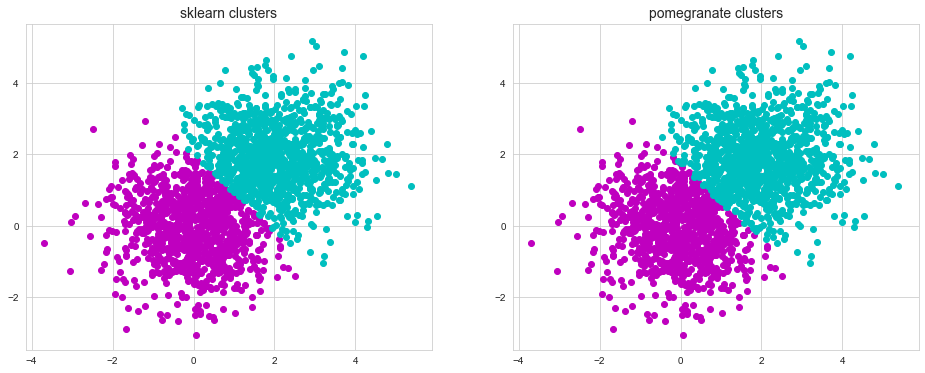

In [8]:
X, y = create_dataset(1000, 2, 2, alpha=2)

a = GaussianMixture(2, n_init=1, max_iter=25).fit(X)
b = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, X, max_iterations=25)

y1, y2 = a.predict(X), b.predict(X)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title("sklearn clusters", fontsize=14)
plt.scatter(X[y1==0, 0], X[y1==0, 1], color='m', edgecolor='m')
plt.scatter(X[y1==1, 0], X[y1==1, 1], color='c', edgecolor='c')

plt.subplot(122)
plt.title("pomegranate clusters", fontsize=14)
plt.scatter(X[y2==0, 0], X[y2==0, 1], color='m', edgecolor='m')
plt.scatter(X[y2==1, 0], X[y2==1, 1], color='c', edgecolor='c')

plt.show()

It looks like we're getting the same basic results for the two. The two algorithms are initialized a bit differently, and so it can be difficult to directly compare the results between them, but it looks like they're getting roughly the same results.

### 3. Multivariate Gaussian HMM

Now let's move on to training a hidden Markov model with multivariate Gaussian emissions with a diagonal covariance matrix. We'll randomly generate some Gaussian distributed numbers and use pomegranate with either one or four threads to fit our model to the data.

In [9]:
X = numpy.random.randn(1000, 500, 50)

print("pomegranate Gaussian HMM (1 job)")
%timeit -n 1 -r 1 HiddenMarkovModel.from_samples(NormalDistribution, 5, X, max_iterations=5)
print()
print("pomegranate Gaussian HMM (2 jobs)")
%timeit -n 1 -r 1 HiddenMarkovModel.from_samples(NormalDistribution, 5, X, max_iterations=5, n_jobs=2)

pomegranate Gaussian HMM (1 job)
17.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

pomegranate Gaussian HMM (2 jobs)
26.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


All we had to do was pass in the n_jobs parameter to the fit function in order to get a speed improvement. It looks like we're getting a really good speed improvement, as well! This is mostly because the HMM algorithms perform a lot more operations than the other models, and so spend the vast majority of time with the GIL released. You may not notice as strong speedups when using a MultivariateGaussianDistribution because BLAS uses multithreaded operations already internally, even when only one job is specified.

Now lets look at the prediction function to make sure the we're getting speedups there as well. You'll have to use a wrapper function to parallelize the predictions for a HMM because it returns an annotated sequence rather than a single value like a classic machine learning model might.

In [10]:
model = HiddenMarkovModel.from_samples(NormalDistribution, 5, X, max_iterations=2, verbose=False)

print("pomegranate Gaussian HMM (1 job)")
%timeit predict_proba(model, X)
print()
print("pomegranate Gaussian HMM (2 jobs)")
%timeit predict_proba(model, X, n_jobs=2)

pomegranate Gaussian HMM (1 job)
3.87 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

pomegranate Gaussian HMM (2 jobs)
8.96 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Great, we're getting a speedup on that as well, albiet a minor one. 

### Conclusions

Hopefully you'll find pomegranate useful in your work! Parallelization should allow you to train complex models faster than before. Keep in mind though that there is an overhead to using parallel processing, and so it's possible that on some smaller examples it does not work as well. In general, the bigger the dataset, the closer to a linear speedup you'll get with pomegranate.

If you have any interesting examples of how you've used pomegranate in your work, I'd love to hear about them. In addition I'd like to hear any feedback you may have on features you'd like to see. Please shoot me an email. Good luck!